In [10]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
# 3. Model
class PINN(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(1, 128), nn.Tanh(),
            nn.Linear(128, 64), nn.Tanh(),
            nn.Linear(64, 32), nn.Tanh(),
            nn.Linear(32, 8), nn.Tanh(),
            nn.Linear(8, 1)
        )
    def forward(self, x):
        return self.net(x)

model = PINN().to(device)

Using device: cuda


In [19]:
# 1. Hyperparameters
L, m, hbar = 1.0, 1.0, 1.0
n = 5
k = n * np.pi
E_n = n**2 * np.pi**2 * hbar**2 / (2*m)
N_f = 1000

# 2. Data (collocation & boundaries)
x_b = torch.tensor([[0.0], [L]], requires_grad=True, device=device)
x_norm = torch.linspace(0, L, N_f, device=device).view(-1, 1)


In [20]:
# 4. Physics residual
def physics_residual(x):
    psi = model(x)
    psi_x = torch.autograd.grad(psi, x, grad_outputs=torch.ones_like(psi), create_graph=True)[0]
    psi_xx = torch.autograd.grad(psi_x, x, grad_outputs=torch.ones_like(psi_x), create_graph=True)[0]
    return psi_xx + k**2 * psi

# 5. Weight scheduling
def get_weights(epoch):
    if epoch < 2500:
        return 5.0, 1.0, 3.0, 1.0
    else:
        return 1.0, 5.0, 1.2, 10.0
# 6. Loss function
def loss_fn(epoch, x_f, x_b, x_norm):
    λ_pde, λ_bc, λ_triv, λ_norm = get_weights(epoch)

    res      = physics_residual(x_f)
    loss_pde = torch.mean(res**2)

    psi_b    = model(x_b)
    loss_bc  = torch.mean(psi_b**2)

    psi_n    = model(x_norm)
    integral = torch.trapz(psi_n.squeeze()**2, x_norm.squeeze())
    loss_norm = (integral - 1.0)**2

    m = torch.mean(torch.abs(psi_n))
    loss_triv = λ_triv / (m + 1e-6)**2

    return (λ_pde * loss_pde +
            λ_bc * loss_bc +
            λ_norm * loss_norm + λ_triv*loss_triv)

In [21]:
# 7. Training
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(11001):
    x_f = torch.rand(N_f, 1, requires_grad=True, device=device) * L
    optimizer.zero_grad()
    loss = loss_fn(epoch, x_f, x_b, x_norm)
    loss.backward(retain_graph=True)
    optimizer.step()

    if epoch % 500 == 0:
        print(f"Epoch {epoch:5d} | Loss = {loss.item():.3e}")

Epoch     0 | Loss = 1.342e+04
Epoch   500 | Loss = 4.711e+01
Epoch  1000 | Loss = 4.221e+01
Epoch  1500 | Loss = 4.150e+01
Epoch  2000 | Loss = 5.346e+01
Epoch  2500 | Loss = 1.300e+01
Epoch  3000 | Loss = 1.010e+01
Epoch  3500 | Loss = 9.100e+00
Epoch  4000 | Loss = 8.502e+00
Epoch  4500 | Loss = 7.828e+00
Epoch  5000 | Loss = 7.002e+00
Epoch  5500 | Loss = 8.908e+00
Epoch  6000 | Loss = 6.692e+00
Epoch  6500 | Loss = 5.812e+00
Epoch  7000 | Loss = 1.885e+01
Epoch  7500 | Loss = 5.313e+00
Epoch  8000 | Loss = 7.303e+00
Epoch  8500 | Loss = 4.345e+00
Epoch  9000 | Loss = 1.272e+01
Epoch  9500 | Loss = 5.142e+00
Epoch 10000 | Loss = 5.701e+00
Epoch 10500 | Loss = 5.210e+00
Epoch 11000 | Loss = 3.138e+00


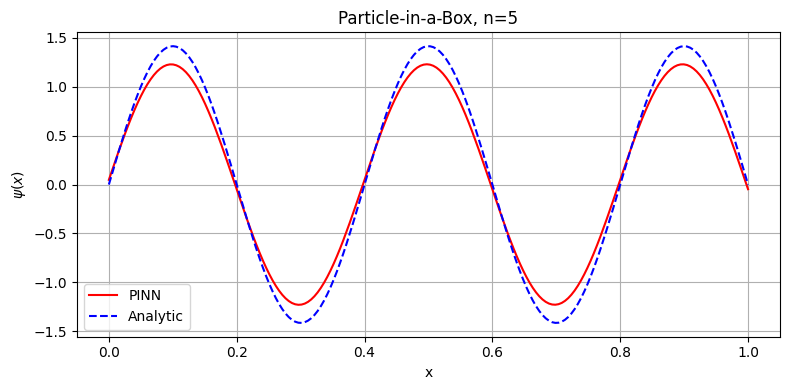

In [22]:
# 8. Plotting
x_plot = np.linspace(0, L, 200).reshape(-1, 1)
x_torch = torch.tensor(x_plot, dtype=torch.float32, device=device)
psi_pred = model(x_torch).detach().cpu().numpy().flatten()
psi_exact = np.sqrt(2) * np.sin(n * np.pi * x_plot.flatten())

plt.figure(figsize=(8, 4))
plt.plot(x_plot, psi_pred, 'r-', label='PINN')
plt.plot(x_plot, psi_exact, 'b--', label='Analytic')
plt.xlabel('x')
plt.ylabel(r'$\psi(x)$')
plt.legend()
plt.title(f'Particle-in-a-Box, n={n}')
plt.grid(True)
plt.tight_layout()
plt.show()

In [34]:
import numpy as np
import pandas as pd

def compute_metrics(psi_pred_tensor, x_tensor, n, L=1.0, hbar=1.0, m=1.0):
    """
    Computes evaluation metrics for the infinite square well problem.

    Parameters:
    - psi_pred_tensor: torch.Tensor of predicted wavefunction values
    - x_tensor: torch.Tensor of spatial grid points
    - n: quantum number (integer)
    - L: width of the well (default is 1.0)
    - hbar: reduced Planck's constant (default is 1.0)
    - m: mass of the particle (default is 1.0)

    Returns:
    - pandas DataFrame containing the computed metrics
    """
    # Ensure tensors are detached and moved to CPU before converting to NumPy
    psi_pred = psi_pred_tensor.detach().cpu().numpy().squeeze()
    x = x_tensor.detach().cpu().numpy().squeeze()

    # Exact wavefunction
    psi_exact = np.sqrt(2 / L) * np.sin(n * np.pi * x / L)

    # Mean Squared Error (MSE)
    mse = np.mean((psi_pred - psi_exact) ** 2)

    # Energy Deviation
    dx = x[1] - x[0]
    psi_xx = np.gradient(np.gradient(psi_pred, dx), dx)
    energy_pred = - (hbar ** 2 / (2 * m)) * np.trapezoid(psi_pred * psi_xx, x)
    energy_exact = (n ** 2 * np.pi ** 2 * hbar ** 2) / (2 * m * L ** 2)
    energy_deviation = abs(energy_pred - energy_exact)

    # Wavefunction Fidelity
    overlap = np.trapezoid(psi_pred * psi_exact, x)
    fidelity = overlap ** 2

    # Correlation Coefficient
    correlation = np.corrcoef(psi_pred, psi_exact)[0, 1]

    # Compile results into a DataFrame
    df = pd.DataFrame({
        'Metric': ['MSE', 'Energy Deviation', 'Fidelity', 'Correlation Coefficient'],
        'Value': [mse, energy_deviation, fidelity, correlation]
    })

    return df

x_norm = torch.linspace(0, L, N_f, device=device).view(-1, 1)
psi_pred = model(x_norm)
metrics_df = compute_metrics(psi_pred, x_norm, n)

In [35]:
metrics_df

,Metric,Value
0,MSE,0.018531
1,Energy Deviation,30.224716
2,Fidelity,0.753912
3,Correlation Coefficient,0.999179
